In [289]:
import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

%matplotlib inline

## Final Modeling

Crunched for time, I attempted a number of combinations of features in the linear regression, adding and removing genre, rating, and director count features in a series of trials.  When my naive attempts at feature engineering yielded no appreciable results, I moved to using PolynomialFeatures.  Finally, I moved to LASSO regression, in the hope that zeroing out some of the coefficients would provide some clarity about the most salient features.

In [106]:
itmb_total = pd.read_json('itmb_total.json', lines=True)

In [107]:
itmb_total.head()

,title,year,release_date,runtime,budget,dom_gross_y,mpaa_rating_G,mpaa_rating_Not Rated,mpaa_rating_PG,mpaa_rating_R,...,director_name,dir_film_ct2,dir_film_ct4,tomatometer,tomato_ct,aud_score,aud_score_ct,imdb_rating,votes,metascore
0,10 Cloverfield Lane,2016.0,"Jan 4, 2016",103.0,15000000,72082999,0,0,0,0,...,Dan Trachtenberg,0,0,90.0,312.0,79.0,"60,968",7.2,289646.0,76.0
1,12 Monkeys,1995.0,"Dec 27, 1995",129.0,29000000,57141459,0,0,0,1,...,Terry Gilliam,1,1,89.0,70.0,88.0,"391,142",8.0,577140.0,74.0
2,2012,2009.0,"Nov 12, 2009",158.0,200000000,166112167,0,0,0,0,...,Roland Emmerich,1,1,39.0,246.0,47.0,"508,352",5.8,352570.0,49.0
3,2046,2004.0,"Nov 19, 2004",129.0,12000000,1442338,0,0,0,1,...,Kar-Wai Wong,0,0,86.0,119.0,85.0,"46,734",7.4,50789.0,78.0
4,28 Weeks Later,2007.0,"May 11, 2007",100.0,15000000,28638916,0,0,0,1,...,Juan Carlos Fresnadillo,0,0,71.0,196.0,66.0,"638,567",7.0,258310.0,78.0


In [108]:
itmb_total['age'] = 2021 - itmb_total['year']

In [109]:
itmb_total.columns

Index(['title', 'year', 'release_date', 'runtime', 'budget', 'dom_gross_y',
       'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance',
       'director_name', 'dir_film_ct2', 'dir_film_ct4', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'imdb_rating', 'votes',
       'metascore', 'age'],
      dtype='object')

In [14]:
pd.set_option('display.max_rows', None)

In [110]:
len(itmb_total.notna())

482

In [111]:
itmb_total = itmb_total[itmb_total['runtime'].notna()]

In [112]:
itmb_total = itmb_total[itmb_total['budget'].notna()]

In [113]:
itmb_total.shape

(474, 32)

In [114]:
itmb_total = itmb_total[itmb_total['age'].notna()]

In [38]:
X_nums = itmb_total[['budget','age']]
y = itmb_total[ 'dom_gross_y']

nums_lr = LinearRegression()
nums_lr.fit(X_nums, y)

LinearRegression()

In [39]:
nums_lr.coef_

array([1.16603330e+00, 1.83830962e+05])

In [40]:
nums_lr.score(X_nums, y)

0.4105662276843586

In [41]:
nums_lr.intercept_

-1876893.037209466

In [115]:
def split_and_validate(X,y):
    '''
    For a set of features and target X, y, perform a 60/20/20 train/validate split,
    fit and validate a linear regression model, and report results.'''
    
    # perform modeling/testing split
    X_model, X_test, y_model, y_test = \
    train_test_split(X, y, test_size=0.2, random_state =42)
    
    # perform train/validate split
    X_train, X_val, y_train, y_val = \
    train_test_split(X_model, y_model, test_size=0.2, random_state=33)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('Validation r^2: ', val_score)
    print('Feature coefficients: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ' : ', f'{coef:.2f}')
    
    
    

In [116]:
split_and_validate(X_nums, y)

Validation r^2:  0.3982913674245433
Feature coefficients: 

budget  :  1.17
age  :  45046.83


In [117]:
itmb_total['budget_x_age'] = itmb_total['budget'] * itmb_total['age']

In [118]:
X_nums_2 =  itmb_total[['budget','age', 'budget_x_age']]
y = itmb_total[ 'dom_gross_y']

In [119]:
split_and_validate(X_nums_2, y)

Validation r^2:  0.41353991756202113
Feature coefficients: 

budget  :  1.34
age  :  620259.80
budget_x_age  :  -0.02


In [120]:
budget = itmb_total[['budget']]

In [59]:
itmb_total.columns

Index(['title', 'year', 'release_date', 'runtime', 'budget', 'dom_gross_y',
       'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance',
       'director_name', 'dir_film_ct2', 'dir_film_ct4', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'imdb_rating', 'votes',
       'metascore', 'age', 'budget_x_age'],
      dtype='object')

In [121]:
itmb_total.columns

Index(['title', 'year', 'release_date', 'runtime', 'budget', 'dom_gross_y',
       'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance',
       'director_name', 'dir_film_ct2', 'dir_film_ct4', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'imdb_rating', 'votes',
       'metascore', 'age', 'budget_x_age'],
      dtype='object')

In [63]:
X_action = itmb_total[['budget','genre_01_Action']]
X_adventure = itmb_total[['budget', 'genre_01_Adventure']]
X_dir_film_ct2 = itmb_total[['budget', 'dir_film_ct2']]
X_dir_film_ct4 = itmb_total[['budget', 'dir_film_ct4']]
X_R_rated = itmb_total[['budget','mpaa_rating_R' ]]
X_PG_rated = itmb_total[['budget','mpaa_rating_PG']]
X_G_rated = itmb_total[['budget','mpaa_rating_G']]
X_comedy = itmb_total[['budget','genre_01_Comedy']]
X_drama = itmb_total[['budget',]]
X_drama = itmb_total[['budget','genre_01_Drama']]
X_horror = itmb_total[['budget','genre_01_Horror']]
X_fantasy = itmb_total[['budget','genre_01_Fantasy']]

In [64]:
split_and_validate(X_action, y)

Validation r^2:  0.3982250029292361
Feature coefficients: 

budget  :  1.16
genre_01_Action  :  1487667.93


In [65]:
split_and_validate(X_adventure, y)

Validation r^2:  0.39856912028879854
Feature coefficients: 

budget  :  1.17
genre_01_Adventure  :  353666.53


In [104]:
X_genre = itmb_total[['budget','genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance']]

In [67]:
# Family movies are not box office earners
split_and_validate(X_genre, y)


Validation r^2:  0.3996852901679694
Feature coefficients: 

budget  :  1.16
genre_01_Action  :  21888630.07
genre_01_Adventure  :  21348381.50
genre_01_Animation  :  25818963.53
genre_01_Comedy  :  15852643.35
genre_01_Crime  :  29152831.74
genre_01_Drama  :  24994404.50
genre_01_Family  :  -68341267.78
genre_01_Fantasy  :  19987601.16
genre_01_Horror  :  18952970.94
genre_01_Mystery  :  27290199.34
genre_01_Romance  :  24441656.97


In [68]:
X_genre_2 = itmb_total[['budget','genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama',  'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance']]

In [69]:
split_and_validate(X_genre_2, y)

Validation r^2:  0.39953601334869304
Feature coefficients: 

budget  :  1.15
genre_01_Action  :  33383013.99
genre_01_Adventure  :  32749535.44
genre_01_Animation  :  37352624.71
genre_01_Comedy  :  27223720.38
genre_01_Crime  :  40509091.42
genre_01_Drama  :  36362561.69
genre_01_Fantasy  :  31312076.34
genre_01_Horror  :  30281984.22
genre_01_Mystery  :  38606487.61
genre_01_Romance  :  35853395.03


In [70]:
X_genre_crime =  itmb_total[['budget','genre_01_Crime']]

In [71]:
split_and_validate(X_genre_crime, y)

Validation r^2:  0.3985034225859624
Feature coefficients: 

budget  :  1.17
genre_01_Crime  :  8275921.94


In [72]:
split_and_validate(budget, y)

Validation r^2:  0.39851924292269836
Feature coefficients: 

budget  :  1.16


In [102]:
X_ratings = itmb_total[['budget', 'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R']]

In [74]:
split_and_validate(X_ratings, y)

Validation r^2:  0.40065933817947974
Feature coefficients: 

budget  :  1.15
mpaa_rating_G  :  -29005023.17
mpaa_rating_Not Rated  :  -4162461.90
mpaa_rating_PG  :  -3390763.62
mpaa_rating_R  :  -6602688.46


In [77]:
X_dir_film_cts = itmb_total[['budget','dir_film_ct2', 'dir_film_ct4']]
X_dir_film_cts2 = itmb_total[['budget','dir_film_ct2']]
X_dir_film_cts4 = itmb_total[['budget', 'dir_film_ct4']]

In [76]:
split_and_validate(X_dir_film_cts , y)

Validation r^2:  0.3834240172220591
Feature coefficients: 

budget  :  1.11
dir_film_ct2  :  12173132.74
dir_film_ct4  :  37278987.53


In [78]:
split_and_validate(X_dir_film_cts2 , y)

Validation r^2:  0.3905163807857561
Feature coefficients: 

budget  :  1.12
dir_film_ct2  :  32495397.48


In [79]:
split_and_validate(X_dir_film_cts4 , y)

Validation r^2:  0.38175869829415876
Feature coefficients: 

budget  :  1.12
dir_film_ct4  :  47762646.40


In [80]:
itmb_total.columns

Index(['title', 'year', 'release_date', 'runtime', 'budget', 'dom_gross_y',
       'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance',
       'director_name', 'dir_film_ct2', 'dir_film_ct4', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'imdb_rating', 'votes',
       'metascore', 'age', 'budget_x_age'],
      dtype='object')

In [92]:
itmb_total['tomatometer']

0       90.0
1       89.0
2       39.0
3       86.0
4       71.0
6       96.0
8       68.0
9        6.0
10      40.0
11      44.0
12      81.0
13      69.0
14      83.0
15      11.0
16      90.0
17      98.0
19      33.0
20       1.0
22      88.0
23      66.0
24      23.0
25      65.0
26      14.0
27      38.0
30       8.0
31      50.0
32      90.0
33      82.0
35       2.0
36      96.0
40      17.0
41      36.0
42      34.0
43      27.0
44      38.0
45      71.0
46      36.0
47      89.0
48      82.0
49      64.0
50      50.0
51      87.0
52      90.0
53      88.0
54      58.0
58      58.0
59      31.0
60      62.0
61      91.0
62      79.0
63      44.0
64      39.0
67      32.0
68      37.0
69      92.0
70      85.0
71      53.0
72      29.0
73      94.0
74      66.0
76      70.0
77      77.0
78      51.0
79      22.0
81      44.0
83      44.0
85      76.0
87      90.0
88      69.0
89      85.0
90      84.0
91      42.0
92      25.0
94      45.0
95      30.0
96      75.0
97      58.0

In [100]:
split_and_validate(budget, y_metascore)

Validation r^2:  0.014892487019310674
Feature coefficients: 



TypeError: unsupported format string passed to numpy.ndarray.__format__

In [124]:
itmb_total.columns

Index(['title', 'year', 'release_date', 'runtime', 'budget', 'dom_gross_y',
       'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance',
       'director_name', 'dir_film_ct2', 'dir_film_ct4', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'imdb_rating', 'votes',
       'metascore', 'age', 'budget_x_age'],
      dtype='object')

In [186]:
itmb_total['release_date'] = pd.to_datetime(itmb_total['release_date'])

In [287]:
X = itmb_total[[ 'budget','age','runtime', 'mpaa_rating_R','meta_green',
                'meta_green','mpaa_rating_G', 'mpaa_rating_Not Rated', 
                'mpaa_rating_PG','mpaa_rating_R', 'genre_01_Action', 
                'genre_01_Adventure','genre_01_Animation', 'genre_01_Comedy',
                'genre_01_Crime','genre_01_Drama', 'genre_01_Family', 
                'genre_01_Fantasy','genre_01_Horror', 'genre_01_Mystery', 
                'genre_01_Romance','dir_film_ct2', 'dir_film_ct4', 'year',
                'runtime']]

y = itmb_total[['dom_gross_y']]

In [222]:
def split_and_validate_poly(X,y):
    '''
    For a set of features and target X, y, perform a 60/20/20 train/validate split,
    fit and validate a linear regression model, and report results.'''
    
    # perform modeling/testing split
    X_model, X_test, y_model, y_test = \
    train_test_split(X, y, test_size=0.2, random_state =42)
    
    # perform train/validate split
    X_train, X_val, y_train, y_val = \
    train_test_split(X_model, y_model, test_size=0.2, random_state=33)
    
    # use Standard Scaler
    s = StandardScaler(with_mean=False)
    X_train= s.fit_transform(X_train)
    X_val = s.fit_transform(X_val)
    X_test = s.fit_transform(X_test)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Try to calculate polynomial features
    p = PolynomialFeatures(degree=2, interaction_only=True)
    x_train_poly = p.fit_transform(X_train)
    lr_model.fit(x_train_poly, y_train)
    
    
# score fit model on validation data

    train_score = lr_model.score(x_train_poly, y_train)
    val_score = lr_model.score(p.transform(X_val), y_val)
    test_score = lr_model.score(p.transform(X_test), y_test)
    
    
    # report results
    print('Train r^2: ', train_score)
    print('Validation r^2: ', val_score)
    print('Test r^2: ', test_score)
    print('Feature coefficients: \n')
#     for feature, coef in zip(p.get_feature_names(), lr_model.coef_):
#         print(feature, ' : ', f'{coef:.2f}')
    print(p.get_feature_names())
    print(lr_model.coef_)
    

In [282]:
itmb_total['certified_fresh'] = np.where(itmb_total['tomatometer']>= 60, 1,0)

In [283]:
itmb_total['meta_green']= np.where(itmb_total['metascore']>= 60, 1,0)

In [285]:
# budget, age, runtime, mpaa R, certified fresh, meta green
split_and_validate_poly(X,y)

Train r^2:  0.5948249805591102
Validation r^2:  0.340931078061244
Test r^2:  0.2880280969201552
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x2 x3', 'x2 x4', 'x2 x5', 'x3 x4', 'x3 x5', 'x4 x5']
[[        0.          22964861.72872968 -90983270.71020313
  -20029182.9767588   36098728.73407796 -19804661.76457955
   -4650845.95099973  -1876354.51091819   3119669.35787665
   -2261907.6851609   -8674498.44235275  29349041.5250974
   15292270.2369281    1703440.60611709   2026044.87324077
   -3473159.32828184  -6510631.6358632    4848502.31736832
    -187775.71052865  -3085420.02209366   1982054.35479344
    2057956.29854009]]


In [286]:
# budget, age, runtime, mpaa R, certified fresh
split_and_validate_poly(X,y)

Train r^2:  0.5948249805591102
Validation r^2:  0.340931078061244
Test r^2:  0.2880280969201552
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x2 x3', 'x2 x4', 'x2 x5', 'x3 x4', 'x3 x5', 'x4 x5']
[[        0.          22964861.72872968 -90983270.71020313
  -20029182.9767588   36098728.73407796 -19804661.76457955
   -4650845.95099973  -1876354.51091819   3119669.35787665
   -2261907.6851609   -8674498.44235275  29349041.5250974
   15292270.2369281    1703440.60611709   2026044.87324077
   -3473159.32828184  -6510631.6358632    4848502.31736832
    -187775.71052865  -3085420.02209366   1982054.35479344
    2057956.29854009]]


In [288]:
# budget, age, runtime, mpaa R,  meta green
split_and_validate_poly(X,y)

Train r^2:  0.5885473584543851
Validation r^2:  0.36228029844412735
Test r^2:  0.3362423459756019
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[        0.          12904185.4077333  -84258726.18120906
  -17844819.70322445  29224130.88810363  -4357760.30335903
   -1561081.66415313   4142199.27055883  -3467489.96048385
   24858039.28864082  14329443.06260286   1887010.10816852
   -3376294.79653556  -5461140.56765048   1222689.76401541
     546860.87958824]]


In [193]:
split_and_validate_poly(X,y)

Train r^2:  0.5206145225624539
Validation r^2:  -4.795295084630917e+25
Test r^2:  -8.373043774053037e+25
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x1 x15', 'x1 x16', 'x1 x17', 'x1 x18', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14', 'x2 x15', 'x2 x16', 'x2 x17', 'x2 x18', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x3 x14', 'x3 x15', 'x3 x16', 'x3 x17', 'x3 x18', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14', 'x4 x15', 'x4 x16

In [196]:
# removed everything except runtime and budget

split_and_validate_poly(X,y)

Train r^2:  0.4527662520078165
Validation r^2:  0.3699108474566143
Test r^2:  0.3540685674447437
Feature coefficients: 

['1', 'x0', 'x1', 'x0 x1']
[[        0.          -3910030.57449934 -28454902.18167406
   13059239.14254836]]


In [199]:
# runtime, budget, year
split_and_validate_poly(X,y)

Train r^2:  0.46420158903516695
Validation r^2:  0.33716914254073704
Test r^2:  -1.467351106324558
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x0 x1', 'x0 x2', 'x1 x2']
[[ 0.00000000e+00  2.15914670e+09 -2.25122560e+09  6.72718673e+07
   1.47201991e+07 -1.19791089e+07  1.22160865e+07]]


In [201]:
# runtime, budget, age    
# best base numbers seem to come with including all of these
# age better than year


split_and_validate_poly(X,y)

Train r^2:  0.4642015890351693
Validation r^2:  0.37465359174547663
Test r^2:  0.346840829962755
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x0 x1', 'x0 x2', 'x1 x2']
[[        0.         -22932953.85283649 -25978809.3883125
  -67271867.34576826  14720199.06652909  11979108.94037254
  -12216086.47006724]]


In [216]:
# runtime, budget, age   
# best base numbers seem to come with including all of these
# age better than year

# rerunning with polynomial degrees, not just interaction terms

split_and_validate_poly(X,y)

Train r^2:  0.5068043890336564
Validation r^2:  0.34654450852350793
Test r^2:  0.2381696806262228
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2', 'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3']
[[ 0.00000000e+00  4.42951198e+08 -6.90458322e+07 -6.25703704e+08
   1.73209474e+07  8.70010114e+06 -1.27358186e+08  6.75980369e+07
  -2.51293886e+07  1.03174445e+08 -8.74138441e+06 -2.50107069e+07
   7.60062696e+06 -1.20015637e+07  8.80613700e+06  7.88172264e+06
  -1.25685002e+06 -8.84390746e+06  4.99221541e+06 -5.73357783e+06]]


In [203]:
#  budget, age
split_and_validate_poly(X,y)

Train r^2:  0.42466952285451476
Validation r^2:  0.3991068397605475
Test r^2:  0.3197777454651576
Feature coefficients: 

['1', 'x0', 'x1', 'x0 x1']
[[        0.          76404101.0850435    6881670.34244465
  -10290534.20916248]]


In [235]:
# budget, runtime, age, mpaa ratings
split_and_validate_poly(X,y)

Train r^2:  0.48098964704089253
Validation r^2:  0.3573759806233151
Test r^2:  0.37123492977107053
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x3 x4', 'x3 x5', 'x3 x6', 'x4 x5', 'x4 x6', 'x5 x6']
[[ 9.22812324e-09 -3.49190449e+07 -7.03816904e+07 -9.67672708e+06
   3.34942991e+07  1.18212631e+07  3.17797926e+07  6.47869943e+07
  -1.67819853e+07  1.49693747e+07  3.96517200e+06  5.39925117e+06
   1.22662444e+07  4.15122909e+06  1.33746300e+07  9.00487021e+05
   5.79448873e+06  1.23652293e+06 -2.21232882e+06 -7.21325416e+06
  -3.09203369e+06 -7.46708857e+06 -1.11880014e+07  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


In [237]:
# budget, runtime, age, mpaa_R   ***
split_and_validate_poly(X,y)

Train r^2:  0.46941097465214765
Validation r^2:  0.3784787229753347
Test r^2:  0.370166784407281
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x0 x1', 'x0 x2', 'x0 x3', 'x1 x2', 'x1 x3', 'x2 x3']
[[        0.         -19008652.10660049 -57028839.77533293
  -12891034.53666076  38079600.29471074 -11298391.2466154
   13206691.34348051  -1389469.08058425  10138521.30395881
    -235107.07395884  -6484970.47930085]]


In [239]:
# budget, runtime, age, mpaa_R, genre action  
split_and_validate_poly(X,y)

Train r^2:  0.48167030773012853
Validation r^2:  0.3650489739986267
Test r^2:  0.38240997767731144
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[        0.         -18575115.70610734 -59238915.44520973
  -17798448.70915037  40583136.65599295 -22548070.42214656
  -12154125.99851059  15839272.48436004  -3208894.83635932
  -12441760.36562573  10531413.56340333   -922549.94389939
     319105.75067995  -6964016.47409093   4472566.40449986
    3200848.32182175]]


In [241]:
## budget, runtime, age, mpaa_R, genre adventure (adventure added nothing)
split_and_validate_poly(X,y)

Train r^2:  0.4725276837308663
Validation r^2:  0.3805482602284066
Test r^2:  0.36973324510121386
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[        0.         -19567606.87048668 -57086935.51113366
  -13611183.06765573  33484932.55563725 -25924219.30444808
  -10508940.66323569  13237096.91329258  -1343706.3801287
   -5950792.6877756    9685457.09159502    835170.18916546
    2425346.42972336  -5960713.91716277   4208048.12284363
     510570.95595301]]


In [243]:
## budget, runtime, age, mpaa_R, genre comedy
split_and_validate_poly(X,y)

Train r^2:  0.4700977607057435
Validation r^2:  0.3780206824277389
Test r^2:  0.3677193391120177
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[        0.         -16750510.8411435  -58315838.76892941
  -12172012.95024534  37723951.4227282   15920207.16281092
  -10987120.0564891   12863747.07393808  -2047799.33414204
   -3455327.67826799  10266891.57874668   -188241.71710578
      60169.96485977  -6280305.59127786  -2086892.14949669
   -1893500.06849378]]


In [249]:
## budget, runtime, age, mpaa_R, genre horror
split_and_validate_poly(X,y)

Train r^2:  0.4703828275016836
Validation r^2:  0.37808926078439486
Test r^2:  0.3655027702981932
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[        0.         -21950594.02598368 -57874001.25579289
  -13795970.83385192  40611831.17901478 -19687655.29575132
  -10888320.35461174  13550312.21320082   -570315.59910109
   -4204182.72105505  10179592.23943535   -335153.58825607
    1315167.23066271  -6977525.22169375   2924362.0893449
     707595.76583018]]


In [251]:
## budget, runtime, age, mpaa_R, genre drama
split_and_validate_poly(X,y)

Train r^2:  0.47535236686949944
Validation r^2:  0.3644318058216295
Test r^2:  0.3519031509278032
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[        0.         -14032902.43269976 -51430238.09016929
   -9260992.09094695  32425582.56166334  45616037.91511525
  -11128680.6232721   12434837.37287707  -3712913.11462397
    8548685.5933219    9362046.08698873   -599117.10316771
    -698354.68511675  -4999746.36623412  -7621188.57763917
    -424565.33221469]]


In [245]:
## budget, runtime, age, mpaa_R, genre crime
split_and_validate_poly(X,y)

Train r^2:  0.469416092281815
Validation r^2:  0.37848244036794354
Test r^2:  0.37019879811411127
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[ 0.00000000e+00 -1.89659114e+07 -5.70217254e+07 -1.28517032e+07
   3.81428493e+07 -4.54091526e+03 -1.13025415e+07  1.31971230e+07
  -1.37567938e+06 -2.47422311e+03  1.01379512e+07 -2.35993126e+05
  -8.59493237e+03 -6.49919077e+06 -3.09320709e+04  0.00000000e+00]]


In [253]:
# budget, runtime, age, mpaa_R, dir film ct 4
split_and_validate_poly(X,y)

Train r^2:  0.49498172065625257
Validation r^2:  0.35667462854823606
Test r^2:  0.34488163232094204
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[        0.           7694367.20970263 -32281157.95035451
  -11081116.99073472  35354769.07703567 -61952699.53406574
  -13628245.27192185   9450580.01708039   1286979.09964061
     931536.3352044    5702952.70790577  -1632965.996077
   11081343.30651047  -5563784.59421128   8140246.28671847
   -5163250.20176486]]


In [255]:
# budget, runtime, age, mpaa_R, dir film ct 2
split_and_validate_poly(X,y)

Train r^2:  0.48634843402329464
Validation r^2:  0.39288423123024463
Test r^2:  0.3412558388344312
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1 x2', 'x1 x3', 'x1 x4', 'x2 x3', 'x2 x4', 'x3 x4']
[[        0.         -10213605.16179983 -41606132.27776929
  -13347481.70504045  28857629.44401006  -9495432.18634031
  -10828162.555164    11551402.82387435    502978.25715453
    1083604.89073783   6820838.26862481   -328945.21127868
    7260907.39392764  -4619164.65602346   2009335.39872835
   -8580598.24356229]]


In [211]:
# budget, runtime, age, mpaa_rated, excluding Not Rated
split_and_validate_poly(X,y)

Train r^2:  0.4796596082144481
Validation r^2:  0.3584871044664777
Test r^2:  0.37023462065153334
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x2 x3', 'x2 x4', 'x2 x5', 'x3 x4', 'x3 x5', 'x4 x5']
[[        0.         -38116617.53727343 -72130764.76498553
  -13349840.79197963  32000561.82370629  27547807.82948709
   58894813.58095961 -16534995.35214881  15694890.35748956
    3806563.64203649  11759590.18086347   3151161.7154973
   13712280.35969468    874888.31270427   1111318.2643248
   -2420691.71222724  -6924408.22340872  -6615936.77101689
   -9969072.73418104         0.                 0.
          0.        ]]


In [155]:
# removed 'genre_01_Romance',
split_and_validate_poly(X,y)

Train r^2:  0.46413840544431373
Validation r^2:  0.41476069878341315
Test r^2:  0.34430201556354123
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x1 x14', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x2 x14', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x3 x14', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x4 x14', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x5 x13', 'x5 x14', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x6 x13', 'x6 x14', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12',

In [158]:
#removed 'genre_01_Mystery', 
split_and_validate_poly(X,y)

Train r^2:  0.4626695301273429
Validation r^2:  0.4134306705856249
Test r^2:  0.3467858812054607
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x5 x13', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x6 x13', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x7 x13', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x8 x13', 'x9 x10', 'x9 x11', 

In [161]:
# removed all genres, only budget, budget x age, mpaa ratings
''''genre_01_Action', 'genre_01_Adventure', 'genre_01_Animation', 
                'genre_01_Comedy', 'genre_01_Crime', 'genre_01_Drama', 
                 'genre_01_Fantasy', 'genre_01_Horror', '''

split_and_validate_poly(X,y)

Train r^2:  0.432890988339401
Validation r^2:  0.39731058219780613
Test r^2:  0.3489428639000085
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x2 x3', 'x2 x4', 'x2 x5', 'x3 x4', 'x3 x5', 'x4 x5']
[[ 0.00000000e+00  1.15816372e+00 -8.82823990e-03 -3.01100238e-08
   1.69210334e-10  1.63657514e-09 -3.33165940e-09  6.12103385e-11
  -8.82823990e-03  2.20512053e-01  2.88183558e-01  3.50108080e-02
   5.20910955e-04 -4.05028392e-02 -3.03659677e-02 -1.75707004e-02
  -4.03745789e-08  2.22878095e-08 -9.40762209e-09  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [163]:
# removed all mpaa ratings, only budget, budget x age, genres
split_and_validate_poly(X,y)

Train r^2:  0.4540059487722117
Validation r^2:  0.40910474413852815
Test r^2:  0.3352000780788693
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x8', 'x1 x9', 'x1 x10', 'x1 x11', 'x1 x12', 'x1 x13', 'x2 x3', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x8', 'x2 x9', 'x2 x10', 'x2 x11', 'x2 x12', 'x2 x13', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x7', 'x3 x8', 'x3 x9', 'x3 x10', 'x3 x11', 'x3 x12', 'x3 x13', 'x4 x5', 'x4 x6', 'x4 x7', 'x4 x8', 'x4 x9', 'x4 x10', 'x4 x11', 'x4 x12', 'x4 x13', 'x5 x6', 'x5 x7', 'x5 x8', 'x5 x9', 'x5 x10', 'x5 x11', 'x5 x12', 'x5 x13', 'x6 x7', 'x6 x8', 'x6 x9', 'x6 x10', 'x6 x11', 'x6 x12', 'x6 x13', 'x7 x8', 'x7 x9', 'x7 x10', 'x7 x11', 'x7 x12', 'x7 x13', 'x8 x9', 'x8 x10', 'x8 x11', 'x8 x12', 'x8 x13', 'x9 x10', 'x9 x11',

In [171]:
itmb_total.columns

Index(['title', 'year', 'release_date', 'runtime', 'budget', 'dom_gross_y',
       'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance',
       'director_name', 'dir_film_ct2', 'dir_film_ct4', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'imdb_rating', 'votes',
       'metascore', 'age', 'budget_x_age'],
      dtype='object')

In [181]:
itmb_total['budget_sq'] = itmb_total['budget']**2
budget_sq = itmb_total[['budget_sq']]

In [346]:
itmb_total['budget_2x'] = itmb_total['budget']*2
budget_2x = itmb_total[['budget_2x']]

In [179]:
split_and_validate_poly(budget, y)

Train r^2:  0.4195260147516169
Validation r^2:  0.3843886212575057
Test r^2:  0.31329664756783515
Feature coefficients: 

['1', 'x0']
[[       0.         66277093.08808333]]


In [182]:
split_and_validate_poly(budget_sq, y)

Train r^2:  0.3905431590167455
Validation r^2:  0.38163575506440595
Test r^2:  0.3433509367841999
Feature coefficients: 

['1', 'x0']
[[       0.         63946756.50500221]]


In [347]:
split_and_validate_poly(budget_2x, y)

Train r^2:  0.4195260147516169
Validation r^2:  0.3843886212575057
Test r^2:  0.31329664756783515
Feature coefficients: 

['1', 'x0']
[       0.         66277093.08808333]


In [177]:
X_final = itmb_total[['budget','age']]
y = itmb_total[['dom_gross_y']]

In [178]:
split_and_validate_poly(X_final, y)

Train r^2:  0.42466952285451476
Validation r^2:  0.3991068397605475
Test r^2:  0.3197777454651576
Feature coefficients: 

['1', 'x0', 'x1', 'x0 x1']
[[        0.          76404101.0850435    6881670.34244465
  -10290534.20916248]]


In [265]:
itmb_ratings = itmb_total[itmb_total['tomatometer'].notna()]
itmb_ratings = itmb_ratings[itmb_ratings['imdb_rating'].notna()]
itmb_ratings= itmb_ratings[itmb_ratings['metascore'].notna()]
itmb_ratings = itmb_ratings[itmb_ratings['dom_gross_y'].notna()]


In [261]:
X = itmb_ratings[[ 'budget','age','runtime', 'mpaa_rating_R', 'dir_film_ct2' ]]
'''
3.34942991e+07  1.18212631e+07  3.17797926e+07  6.47869943e+07
  -1.67819853e+07 

       'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance',
        'dir_film_ct2', 'dir_film_ct4', 'year','runtime', 
'''
y = itmb_ratings[['dom_gross_y']]

In [262]:
y_tomato = itmb_ratings[['tomatometer']]
y_imdb_rate = itmb_ratings[['imdb_rating']]
y_metascore = itmb_ratings[['metascore']]
budget = itmb_ratings[['budget']]
X_nums = itmb_ratings[['budget', 'runtime', 'age', 'dom_gross_y']]

In [266]:
itmb_ratings.shape

(330, 34)

In [274]:
X_rate = itmb_ratings[['budget', 'age', 'runtime', 'dom_gross_y']]
y_rate = itmb_ratings[['imdb_rating']]

In [272]:
# y = metascore
split_and_validate_poly(X_rate,y_rate)

Train r^2:  0.1319300382445514
Validation r^2:  0.07423634936821788
Test r^2:  0.20458105589505815
Feature coefficients: 

['1', 'x0', 'x1', 'x0 x1']
[[ 0.         -2.22992395 10.73771536 -1.22866149]]


In [275]:
# y = imdb rating
split_and_validate_poly(X_rate,y_rate)

Train r^2:  0.261780790662952
Validation r^2:  0.3137446369125989
Test r^2:  0.1885454545904085
Feature coefficients: 

['1', 'x0', 'x1', 'x2', 'x3', 'x0 x1', 'x0 x2', 'x0 x3', 'x1 x2', 'x1 x3', 'x2 x3']
[[ 0.          0.27975573  0.6028312   0.62243186  0.65892441 -0.15730866
  -0.05415193 -0.10669328 -0.09664266  0.15678424 -0.01940743]]


In [280]:
itmb_ratings['certified_fresh'] = np.where(itmb_ratings['tomatometer']>= 60, 1,0)



In [ ]:
def split_and_validate(X,y):
    '''
    For a set of features and target X, y, perform a 60/20/20 train/validate split,
    fit and validate a linear regression model, and report results.'''
    
    # perform modeling/testing split
    X_model, X_test, y_model, y_test = \
    train_test_split(X, y, test_size=0.2, random_state =42)
    
    # perform train/validate split
    X_train, X_val, y_train, y_val = \
    train_test_split(X_model, y_model, test_size=0.2, random_state=33)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('Validation r^2: ', val_score)
    print('Feature coefficients: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ' : ', f'{coef:.2f}')
    
    
    

In [ ]:
#     # score fit model on validation data
#     val_score = lr_model.score(X_val, y_val)
    train_score = lr_model.score(x_train_poly, y_train)
    val_score = lr_model.score(p.transform(X_val), y_val)
    test_score = lr_model.score(p.transform(X_test), y_test)
    
    
    # report results
    print('Train r^2: ', train_score)
    print('Validation r^2: ', val_score)
    print('Test r^2: ', test_score)
    print('Feature coefficients: \n')
#     for feature, coef in zip(p.get_feature_names(), lr_model.coef_):
#         print(feature, ' : ', f'{coef:.2f}')
    print(p.get_feature_names())
    print(lr_model.coef_)
    

In [292]:
itmb_total.columns

Index(['title', 'year', 'release_date', 'runtime', 'budget', 'dom_gross_y',
       'mpaa_rating_G', 'mpaa_rating_Not Rated', 'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama', 'genre_01_Family', 'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 'genre_01_Romance',
       'director_name', 'dir_film_ct2', 'dir_film_ct4', 'tomatometer',
       'tomato_ct', 'aud_score', 'aud_score_ct', 'imdb_rating', 'votes',
       'metascore', 'age', 'budget_x_age', 'budget_sq', 'certified_fresh',
       'meta_green'],
      dtype='object')

In [308]:
X = itmb_total[['budget', 'runtime', 'age',
       'mpaa_rating_G',  'mpaa_rating_PG',
       'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Comedy', 'genre_01_Crime',
       'genre_01_Drama',  'genre_01_Fantasy',
       'genre_01_Horror', 'genre_01_Mystery', 
        'certified_fresh',
       'meta_green']]
y = itmb_total['dom_gross_y']

In [322]:
X = itmb_total[['budget', 'runtime', 'age', 'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Crime','certified_fresh','meta_green']]
y = itmb_total['dom_gross_y']

In [327]:
X = itmb_total[['budget', 'age', 'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Crime','meta_green']]
y = itmb_total['dom_gross_y']

In [337]:
X = itmb_total[['budget', 'age', 'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Crime','certified_fresh']]
y = itmb_total['dom_gross_y']

In [338]:

# perform modeling/testing split
X_model, X_test, y_model, y_test = \
train_test_split(X, y, test_size=0.2, random_state =42)

# perform train/validate split
X_train, X_val, y_train, y_val = \
train_test_split(X_model, y_model, test_size=0.2, random_state=33)







In [339]:
# use Standard Scaler
s = StandardScaler(with_mean=False)
X_train= s.fit_transform(X_train)
X_val = s.fit_transform(X_val)
X_test = s.fit_transform(X_test)

In [340]:
m = LassoCV()
p = PolynomialFeatures(degree=2)
X_train_poly = p.fit_transform(X_train)
m.fit(X_train_poly, y_train)

LassoCV()

In [317]:

train_score = m.score(X_train_poly, y_train)
val_score = m.score(p.transform(X_val), y_val)
test_score = m.score(p.transform(X_test), y_test)


# report results
print('Train r^2: ', train_score)
print('Validation r^2: ', val_score)
print('Test r^2: ', test_score)
print('Feature coefficients: \n')
for feature, coef in zip(p.get_feature_names(), m.coef_):
    print(feature, ' : ', coef)


Train r^2:  0.5709453337802308
Validation r^2:  0.40366665802604984
Test r^2:  0.44643847731653297
Feature coefficients: 

1  :  0.0
x0  :  0.0
x1  :  -0.0
x2  :  0.0
x3  :  -0.0
x4  :  0.0
x5  :  -0.0
x6  :  0.0
x7  :  -0.0
x8  :  0.0
x9  :  -0.0
x10  :  -0.0
x11  :  0.0
x12  :  0.0
x13  :  0.0
x14  :  -0.0
x15  :  0.0
x16  :  0.0
x0^2  :  0.0
x0 x1  :  5955313.885289867
x0 x2  :  0.0
x0 x3  :  0.0
x0 x4  :  0.0
x0 x5  :  -0.0
x0 x6  :  0.0
x0 x7  :  -0.0
x0 x8  :  1395320.8805443032
x0 x9  :  -0.0
x0 x10  :  -0.0
x0 x11  :  0.0
x0 x12  :  0.0
x0 x13  :  0.0
x0 x14  :  -0.0
x0 x15  :  0.0
x0 x16  :  14687185.156993413
x1^2  :  -0.0
x1 x2  :  96725.3700591791
x1 x3  :  -0.0
x1 x4  :  0.0
x1 x5  :  -1068758.8718359752
x1 x6  :  179717.84318303413
x1 x7  :  -157732.78721012123
x1 x8  :  159322.92977594398
x1 x9  :  -0.0
x1 x10  :  -0.0
x1 x11  :  -0.0
x1 x12  :  0.0
x1 x13  :  0.0
x1 x14  :  -0.0
x1 x15  :  449169.1149351653
x1 x16  :  1206517.3633686816
x2^2  :  0.0
x2 x3  :  -0.0
x2 x4

In [ ]:
0 budget
8 Animation
16 metascore green
1 runtime
2 age
5 R rating
6 Action
7 Adventure
10^2 Crime
15 certified fresh tomatometer

In [ ]:
'budget', 'runtime', 'age', 'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Crime','certified_fresh','meta_green'

In [326]:
train_score = m.score(X_train_poly, y_train)
val_score = m.score(p.transform(X_val), y_val)
test_score = m.score(p.transform(X_test), y_test)


# report results
print('Train r^2: ', train_score)
print('Validation r^2: ', val_score)
print('Test r^2: ', test_score)
print('Feature coefficients: \n')
for feature, coef in zip(p.get_feature_names(), m.coef_):
    print(feature, ' : ', coef)


Train r^2:  0.5709453642137088
Validation r^2:  0.4036666325920216
Test r^2:  0.44643846674904986
Feature coefficients: 

1  :  0.0
x0  :  0.0
x1  :  -0.0
x2  :  0.0
x3  :  -0.0
x4  :  0.0
x5  :  -0.0
x6  :  0.0
x7  :  -0.0
x8  :  0.0
x9  :  0.0
x0^2  :  0.0
x0 x1  :  5955305.625880426
x0 x2  :  0.0
x0 x3  :  -0.0
x0 x4  :  0.0
x0 x5  :  -0.0
x0 x6  :  1395300.3808640852
x0 x7  :  -0.0
x0 x8  :  0.0
x0 x9  :  14687225.841207609
x1^2  :  -0.0
x1 x2  :  96725.21870043705
x1 x3  :  -1068758.8899774873
x1 x4  :  179721.1740586732
x1 x5  :  -157731.04443661848
x1 x6  :  159330.0262869706
x1 x7  :  -0.0
x1 x8  :  449171.9267708958
x1 x9  :  1206509.2121008097
x2^2  :  0.0
x2 x3  :  0.0
x2 x4  :  0.0
x2 x5  :  0.0
x2 x6  :  -0.0
x2 x7  :  -0.0
x2 x8  :  0.0
x2 x9  :  -0.0
x3^2  :  -0.0
x3 x4  :  0.0
x3 x5  :  -0.0
x3 x6  :  -0.0
x3 x7  :  0.0
x3 x8  :  -0.0
x3 x9  :  -0.0
x4^2  :  0.0
x4 x5  :  0.0
x4 x6  :  0.0
x4 x7  :  0.0
x4 x8  :  0.0
x4 x9  :  0.0
x5^2  :  -0.0
x5 x6  :  0.0
x5 x7  :  0

In [ ]:
0 budget
8 Animation
9 metascore green
1 runtime
2 age
3 R rating
4 Action
5 Adventure
6 Animation
7 Crime
8 certified fresh tomatometer

In [331]:

train_score = m.score(X_train_poly, y_train)
val_score = m.score(p.transform(X_val), y_val)
test_score = m.score(p.transform(X_test), y_test)


# report results
print('Train r^2: ', train_score)
print('Validation r^2: ', val_score)
print('Test r^2: ', test_score)
print('Feature coefficients: \n')
for feature, coef in zip(p.get_feature_names(), m.coef_):
    print(feature, ' : ', coef)


Train r^2:  0.5474639521143219
Validation r^2:  0.35708519004011186
Test r^2:  0.4041395051931026
Feature coefficients: 

1  :  0.0
x0  :  0.0
x1  :  -0.0
x2  :  -0.0
x3  :  0.0
x4  :  -0.0
x5  :  0.0
x6  :  -0.0
x7  :  0.0
x0^2  :  9989229.717421943
x0 x1  :  0.0
x0 x2  :  -0.0
x0 x3  :  0.0
x0 x4  :  -0.0
x0 x5  :  0.0
x0 x6  :  -0.0
x0 x7  :  21089827.8917991
x1^2  :  -0.0
x1 x2  :  -0.0
x1 x3  :  0.0
x1 x4  :  0.0
x1 x5  :  -0.0
x1 x6  :  -0.0
x1 x7  :  0.0
x2^2  :  -0.0
x2 x3  :  -0.0
x2 x4  :  -0.0
x2 x5  :  -0.0
x2 x6  :  0.0
x2 x7  :  -0.0
x3^2  :  0.0
x3 x4  :  0.0
x3 x5  :  0.0
x3 x6  :  0.0
x3 x7  :  0.0
x4^2  :  -0.0
x4 x5  :  0.0
x4 x6  :  0.0
x4 x7  :  -0.0
x5^2  :  0.0
x5 x6  :  0.0
x5 x7  :  -0.0
x6^2  :  -0.0
x6 x7  :  -0.0
x7^2  :  0.0


In [358]:
X = itmb_total[['budget', 'age', 'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Crime','meta_green']]
y = itmb_total['dom_gross_y']

In [ ]:
0 budget
7 meta_green

In [366]:
X = itmb_total[['budget', 'age', 'mpaa_rating_R', 'genre_01_Action', 'genre_01_Adventure',
       'genre_01_Animation', 'genre_01_Crime','certified_fresh']]
y = itmb_total['dom_gross_y']

In [341]:
train_score = m.score(X_train_poly, y_train)
val_score = m.score(p.transform(X_val), y_val)
test_score = m.score(p.transform(X_test), y_test)


# report results
print('Train r^2: ', train_score)
print('Validation r^2: ', val_score)
print('Test r^2: ', test_score)
print('Feature coefficients: \n')
for feature, coef in zip(p.get_feature_names(), m.coef_):
    print(feature, ' : ', coef)
# print(p.get_feature_names())
# print(m.coef_)

Train r^2:  0.4545561844342657
Validation r^2:  0.38397144768487956
Test r^2:  0.46097513510068955
Feature coefficients: 

1  :  0.0
x0  :  0.0
x1  :  -0.0
x2  :  -0.0
x3  :  0.0
x4  :  -0.0
x5  :  0.0
x6  :  -0.0
x7  :  0.0
x0^2  :  12810763.097372228
x0 x1  :  0.0
x0 x2  :  -0.0
x0 x3  :  0.0
x0 x4  :  0.0
x0 x5  :  0.0
x0 x6  :  -0.0
x0 x7  :  11849041.727560835
x1^2  :  -0.0
x1 x2  :  -0.0
x1 x3  :  0.0
x1 x4  :  0.0
x1 x5  :  -0.0
x1 x6  :  -0.0
x1 x7  :  0.0
x2^2  :  -0.0
x2 x3  :  -0.0
x2 x4  :  -0.0
x2 x5  :  -0.0
x2 x6  :  0.0
x2 x7  :  -0.0
x3^2  :  0.0
x3 x4  :  0.0
x3 x5  :  0.0
x3 x6  :  0.0
x3 x7  :  0.0
x4^2  :  -0.0
x4 x5  :  0.0
x4 x6  :  0.0
x4 x7  :  0.0
x5^2  :  0.0
x5 x6  :  0.0
x5 x7  :  -0.0
x6^2  :  -0.0
x6 x7  :  -0.0
x7^2  :  0.0


In [351]:
itmb_total

,title,year,release_date,runtime,budget,dom_gross_y,mpaa_rating_G,mpaa_rating_Not Rated,mpaa_rating_PG,mpaa_rating_R,...,aud_score_ct,imdb_rating,votes,metascore,age,budget_x_age,budget_sq,certified_fresh,meta_green,budget_2x
0,10 Cloverfield Lane,2016.0,2016-01-04,103.0,15000000,72082999,0,0,0,0,...,"60,968",7.2,289646.0,76.0,5.0,7.500000e+07,225000000000000,1,1,30000000
1,12 Monkeys,1995.0,1995-12-27,129.0,29000000,57141459,0,0,0,1,...,"391,142",8.0,577140.0,74.0,26.0,7.540000e+08,841000000000000,1,1,58000000
2,2012,2009.0,2009-11-12,158.0,200000000,166112167,0,0,0,0,...,"508,352",5.8,352570.0,49.0,12.0,2.400000e+09,40000000000000000,0,0,400000000
3,2046,2004.0,2004-11-19,129.0,12000000,1442338,0,0,0,1,...,"46,734",7.4,50789.0,78.0,17.0,2.040000e+08,144000000000000,1,1,24000000
4,28 Weeks Later,2007.0,2007-05-11,100.0,15000000,28638916,0,0,0,1,...,"638,567",7.0,258310.0,78.0,14.0,2.100000e+08,225000000000000,1,1,30000000
5,9,2009.0,2009-09-09,79.0,30000000,31749894,0,0,0,0,...,None,7.1,133132.0,60.0,12.0,3.600000e+08,900000000000000,0,1,60000000
6,A Quiet Place,2018.0,2018-04-04,90.0,17000000,188024361,0,0,0,0,...,"23,362",7.5,406427.0,82.0,3.0,5.100000e+07,289000000000000,1,1,34000000
7,A Quiet Place Part II,2020.0,2021-04-22,97.0,17000000,0,0,0,0,0,...,None,NaN,NaN,NaN,1.0,1.700000e+07,289000000000000,0,0,34000000
8,A Scanner Darkly,2006.0,2006-07-07,100.0,20000000,5501616,0,0,0,1,...,"140,085",7.1,106357.0,73.0,15.0,3.000000e+08,400000000000000,1,1,40000000
9,A Sound of Thunder,2005.0,2005-09-02,110.0,80000000,1900451,0,0,0,0,...,"43,552",4.3,18850.0,24.0,16.0,1.280000e+09,6400000000000000,0,0,160000000


<AxesSubplot:xlabel='metascore', ylabel='dom_gross_y'>

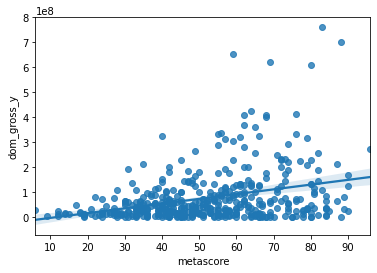

In [364]:
sns.regplot(x=itmb_total['metascore'] ,y=itmb_total['dom_gross_y'], data=itmb_total)

In [355]:
itmb_total['age_sq'] = itmb_total['age']**2

In [365]:

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

ValueError: x and y must be the same size

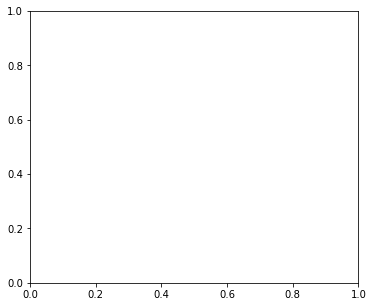

In [367]:
diagnostic_plot(X,y)